### Chemical Property Prediction and Evaluation

This notebook is *designed to perform chemical property prediction* using a *pre-trained model*, evaluate the model's performance using various metrics, and visualize the ROC curve to assess its discriminatory power. The specific chemical property being predicted is 'CYP1A2-inhibitor', and the code is organized into sections for clarity.

In [4]:
# Installing chemprop (https://github.com/chemprop/chemprop) for chemical property prediction
!pip install chemprop

In [5]:
# Importing necessary modules for data analysis and visualization
import subprocess  # Module for executing system commands
import pandas as pd  # Module for data manipulation and analysis
import math  # Module for mathematical operations
import numpy as np  # Module for numerical computations
from sklearn.metrics import roc_curve, auc  # Modules for model evaluation metrics
import matplotlib.pyplot as plt  # Module for creating visualizations

In [6]:
# Applying the trained model to make predictions for a specific chemical property
property_name = 'CYP1A2-inhibitor'  # Name of the target property

"""Get predictions"""
# Creating a command to use chemprop_predict to generate predictions
command = f"chemprop_predict --test_path {property_name}.csv --checkpoint_path {property_name}.pt --preds_path {property_name}_preds.csv"
# Running the command using subprocess to execute it in the shell
subprocess.run(command, shell=True, check=True)

# Loading the generated predictions from the CSV file into a pandas dataFrame
predictions = pd.read_csv(f'{property_name}_preds.csv')
# Displaying the first 10 rows of the predictions dataFrame
predictions.head(10)

,smiles,Activity
0,CCCC(=O)NC1=CC(=C(C=C1)N2CCN(CC2)CC)Cl.Cl,0.046746
1,C1OC2=C(O1)C=C3C(=C2)C=C(C(=O)N3)CN(CCCO)CC4=N...,0.888335
2,CCN1C2=CC=CC=C2/C(=C/3\C(=O)N(C(=S)S3)CCCOC)/C1=O,0.990959
3,CC(=O)N(C1=CC2=C(C=C1)OC(=O)S2)S(=O)(=O)C3=CC=CS3,0.052615
4,C1=CC=C(C=C1)C2=NNC(=N2)C3=CC=CC=C3Cl,0.999324
5,COC1=CC=CC=C1CNC(=O)CN2N=C(N=N2)C3=CC=NC=C3,0.783483
6,C1COCCN1CCN2C3=CC=CC=C3N(C2=N)CC(=O)C4=CC(=C(C...,0.898370
7,COC1=CC=C(C=C1)C2/C(=C(\C3=CC=C(C=C3)OC)/O)/C(...,0.021203
8,COC1=CC=C(C=C1)NC2=NC(=NC(=N2)N)CSC3=NNC(=N3)C...,0.964044
9,CCN1C(=NN=C1SCC(=O)N(CC)CC)C2=CC3=CC=CC=C3C=C2O,0.947298


In [7]:
# Loading the initial dataset and its corresponding activity values for the target property
true = pd.read_csv(f'{property_name}.csv')  # Load the dataset

# Displaying the first 10 rows of the loaded dataset
true.head(10)

,smiles,Activity
0,CCCC(=O)NC1=CC(=C(C=C1)N2CCN(CC2)CC)Cl.Cl,0
1,C1OC2=C(O1)C=C3C(=C2)C=C(C(=O)N3)CN(CCCO)CC4=N...,1
2,CCN1C2=CC=CC=C2/C(=C/3\C(=O)N(C(=S)S3)CCCOC)/C1=O,1
3,CC(=O)N(C1=CC2=C(C=C1)OC(=O)S2)S(=O)(=O)C3=CC=CS3,1
4,C1=CC=C(C=C1)C2=NNC(=N2)C3=CC=CC=C3Cl,1
5,COC1=CC=CC=C1CNC(=O)CN2N=C(N=N2)C3=CC=NC=C3,1
6,C1COCCN1CCN2C3=CC=CC=C3N(C2=N)CC(=O)C4=CC(=C(C...,1
7,COC1=CC=C(C=C1)C2/C(=C(\C3=CC=C(C=C3)OC)/O)/C(...,0
8,COC1=CC=C(C=C1)NC2=NC(=NC(=N2)N)CSC3=NNC(=N3)C...,1
9,CCN1C(=NN=C1SCC(=O)N(CC)CC)C2=CC3=CC=CC=C3C=C2O,1


In [8]:
"""Defining utility functions for metrics calculation"""

# Calculate the mean of activity values from the true dataset
mean = true['Activity'].mean()

# Function to determine whether a value should be rounded up (1) or down (0) based on the mean
def ceil(number):
    if number < mean:
        return 0
    else:
        return 1

# Function to convert a number to an integer
def toInt(number):
    return int(number)

"""Metrics calculation"""

# Mapping the 'ceil' function to prediction activity values and converting to NumPy arrays
pred_labels = np.asarray(list(map(ceil, predictions['Activity'].tolist())))

# Mapping the 'toInt' function to true activity values and converting to NumPy arrays
true_labels = np.asarray(list(map(toInt, true['Activity'].tolist())))

# Calculating true positive, true negative, false positive, and false negative counts
tp = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
tn = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
fp = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
fn = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

# Calculating specificity, sensitivity, accuracy, and balanced accuracy
specificity = tn / (fp + tn)
sensitivity = tp / (fn + tp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
balanced_accuracy = (specificity + sensitivity) / 2

# Displaying the calculated metrics
print(f"True Positives: {tp}")  # True Positives
print(f"True Negatives: {tn}")  # True Negatives
print(f"False Positives: {fp}")  # False Positives
print(f"False Negatives: {fn}")  # False Negatives
print(f"Specificity: {specificity}")  # Specificity
print(f"Sensitivity: {sensitivity}")  # Sensitivity
print(f"Accuracy: {accuracy}")  # Accuracy
print(f"Balanced accuracy: {balanced_accuracy}")  # Balanced Accuracy

True Positives: 5735
True Negatives: 6512
False Positives: 730
False Negatives: 262
Specificity: 0.8991991162662248
Sensitivity: 0.9563114890778722
Accuracy: 0.9250698693254777
Balanced accuracy: 0.9277553026720485


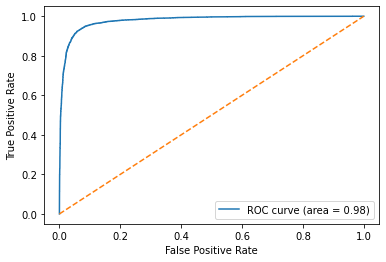

ROC AUC: 0.9782141139611505


In [9]:
# Generating ROC curve data points
fpr, tpr, _ = roc_curve(true_labels, predictions['Activity'].tolist())

# Calculating Area Under the Curve (AUC) for the ROC curve
roc_auc = auc(fpr, tpr)

# Creating a plot for ROC curve visualization
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Displaying the calculated ROC AUC value
print("ROC AUC:", roc_auc)